In [9]:
import pandas as pd
import re, string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy3

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Denis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Denis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('habr articles.csv')

In [4]:
del df['Unnamed: 0']

In [6]:
df

,text
0,"Привет, Хабр! Сегодня разберём, какреализовать..."
1,Старший iOS-разработчик red_mad_robot Аня Коче...
2,"Еще до начала MWC в Барселоне было очевидно, ч..."
3,Взлом Instagram*‑аккаунта — популярный запрос ...
4,"Привет, Хабр! Меня зовут Кирилл Прямов, я мене..."
...,...
1126,"Привет, Хабр! Представляю вашему вниманию пере..."
1127,Источник\n«Умный человек не делает все ошибки ...
1128,"Привет, Хабр! Сегодня мы решили поделиться с с..."
1129,"Привет! Меня зовут Никита Бокарев, я креативны..."


In [10]:
morph = pymorphy3.MorphAnalyzer(lang='ru')
russian_stop_l = set(stopwords.words('russian'))
extra_stop_l = {'в','и','на', 'не','эта'}
stop_l = russian_stop_l | extra_stop_l

def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"[0-9A-Za-z" + re.escape(string.punctuation) + r"]+", " ", text)
    return re.sub(r"\s+", " ", text).strip()

def lemmatize(text: str) -> str:
    return " ".join(morph.parse(tok)[0].normal_form for tok in word_tokenize(text))

def remove_stopwords(text: str) -> str:
    return " ".join(tok for tok in text.split() if tok not in stop_l)

In [11]:
df['processed'] = (
    df['text']
      .astype(str)
      .apply(clean_text)
      .apply(lemmatize)
      .apply(remove_stopwords)
)

In [14]:
tfidf = TfidfVectorizer(
    max_df=0.75,
    min_df=0.01,
    max_features=15000,
    ngram_range=(1,3),
    stop_words=list(stop_l)
)
X_tfidf = tfidf.fit_transform(df['processed'])

In [13]:
df

,text,processed
0,"Привет, Хабр! Сегодня разберём, какреализовать...",привет хабра сегодня разобрать какреализовать ...
1,Старший iOS-разработчик red_mad_robot Аня Коче...,старший разработчик аня кочешкова рассказывать...
2,"Еще до начала MWC в Барселоне было очевидно, ч...",ещё начало барселона очевидный хотя оператор п...
3,Взлом Instagram*‑аккаунта — популярный запрос ...,взлом ‑аккаунт — популярный запрос поисковик п...
4,"Привет, Хабр! Меня зовут Кирилл Прямов, я мене...",привет хабра звать кирилл прям менеджер развит...
...,...,...
1126,"Привет, Хабр! Представляю вашему вниманию пере...",привет хабра представлять ваш внимание перевод...
1127,Источник\n«Умный человек не делает все ошибки ...,источник « умный человек делать всё ошибка — д...
1128,"Привет, Хабр! Сегодня мы решили поделиться с с...",привет хабра сегодня решить поделиться сообщес...
1129,"Привет! Меня зовут Никита Бокарев, я креативны...",привет звать никита бокарев креативный продюсе...


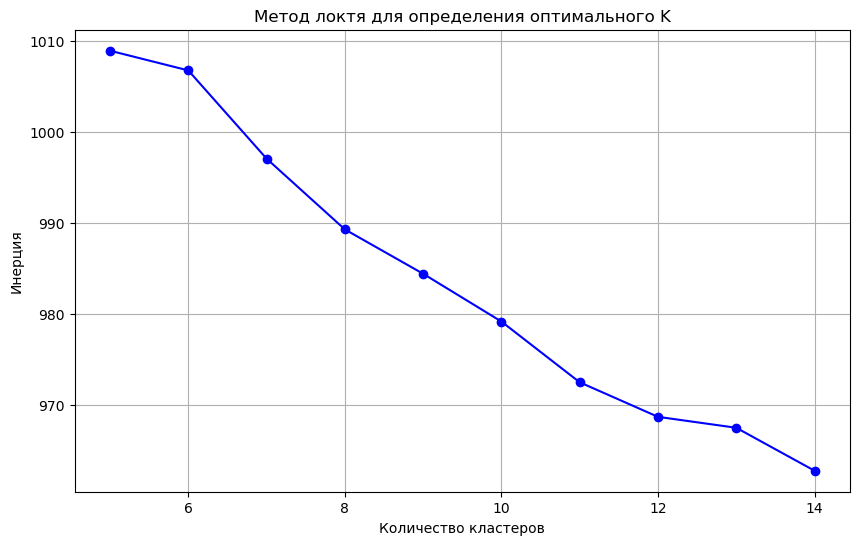

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import pymorphy3
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import string

inertia = []
k_range = range(5, 15)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)

# Визуализация метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.title('Метод локтя для определения оптимального K')
plt.grid(True)
plt.savefig('elbow_method.png', dpi=300)
plt.show()

In [17]:
optimal_k = 8  # Пример, замените на значение из "локтя"

# Кластеризация
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_tfidf)
df['cluster'] = clusters

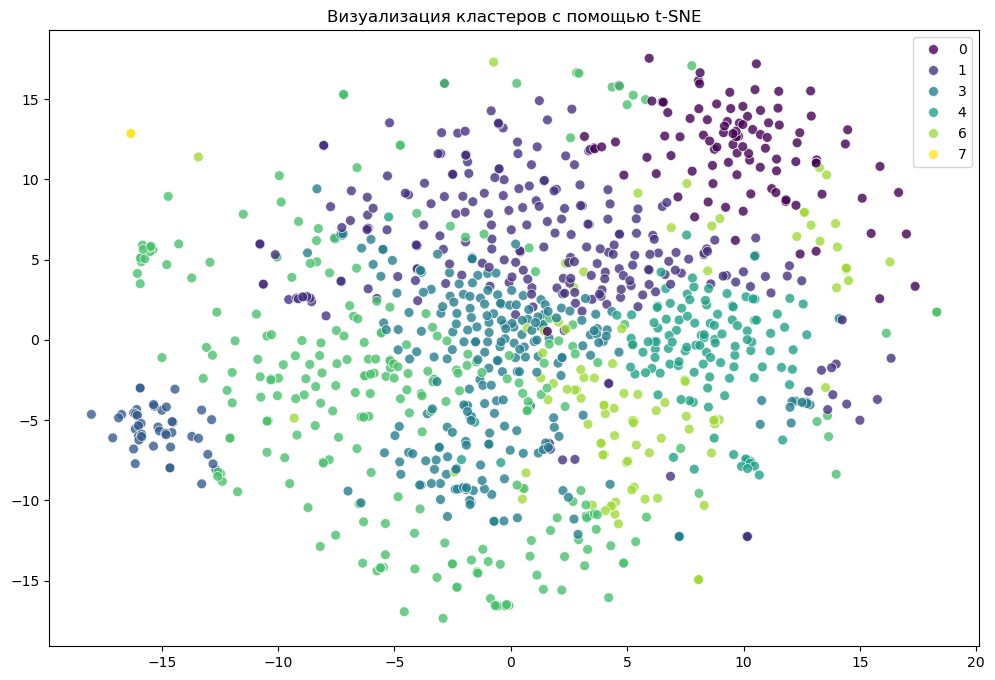

In [18]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_tsne[:, 0], 
    y=X_tsne[:, 1], 
    hue=clusters,
    palette='viridis',
    s=50,
    alpha=0.8
)
plt.title('Визуализация кластеров с помощью t-SNE')
plt.savefig('tsne_clusters.png', dpi=300)
plt.show()

In [25]:
# Получение центроидов кластеров
centroids = kmeans.cluster_centers_

# Словарь терминов
feature_names = tfidf.get_feature_names_out()

# Топ-10 слов для каждого кластера
top_words_per_cluster = {}
for i, centroid in enumerate(centroids):
    # Индексы слов с наибольшими весами
    top_indices = centroid.argsort()[-20:][::-1]
    # Соответствующие слова
    top_words = [feature_names[idx] for idx in top_indices]
    top_words_per_cluster[i] = top_words

    print(f"Кластер {i}: {', '.join(top_words)}")

Кластер 0: студия, лебедев, артемий, артемий лебедев, студия артемий, студия артемий лебедев, сайт, знак, сайт студия, страница, дизайн, логотип, год, дизайнер, клавиатура, проект, студия лебедев, блог, ссылка, компания
Кластер 1: файл, использовать, приложение, модель, человек, устройство, данные, нужно, код, система, год, первый, наш, сделать, например, делать, случай, просто, большой, очень
Кластер 2: такси, водитель, сервис, яндекс, яндекс такси, агрегатор, компания, услуга, заказ, поездка, фас, рынок, год, россия, москва, доставка, таксист, ситимобила, служба, город
Кластер 3: человек, курс, год, очень, делать, компания, обучение, команда, вопрос, хороший, просто, наш, большой, задача, нужно, проект, игра, первый, говорить, новый
Кластер 4: разработчик, курс, код, приложение, практический, использовать, язык, функция, онлайн курс, программист, практический курс, вебинар, хабра, веб, файл, нужно, рекомендовать, программирование, курс разработчик, проблема
Кластер 5: компания, робот

C:\Users\Denis\AppData\Local\Temp\ipykernel_7652\395493135.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


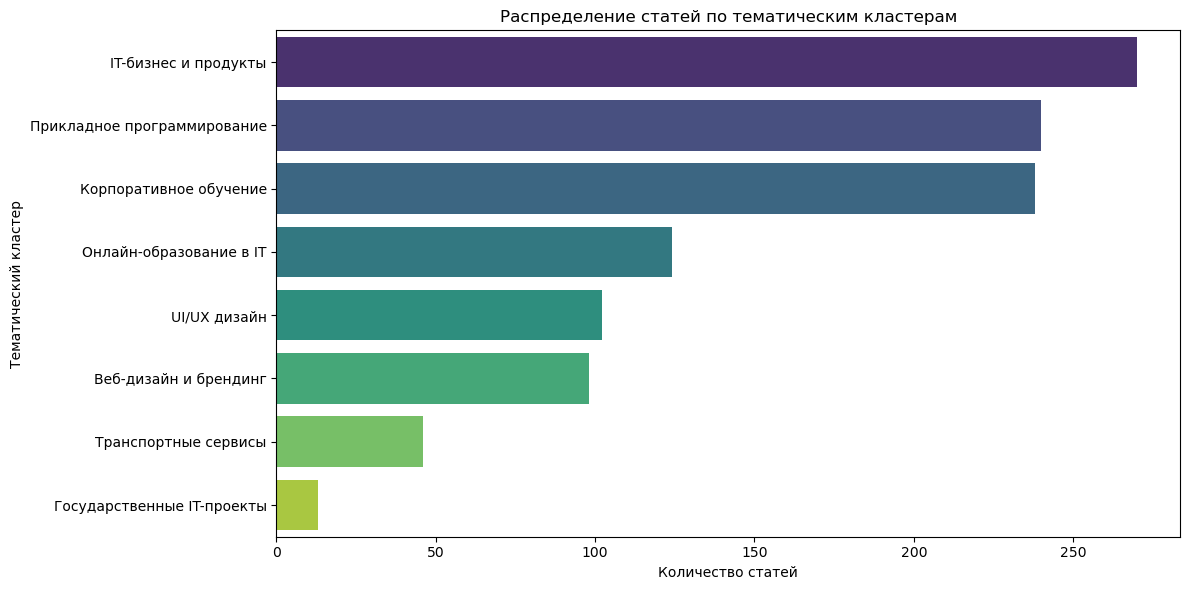

In [27]:
# Создаем словарь соответствия номеров кластеров и их названий
cluster_names = {
    0: "Веб-дизайн и брендинг",
    1: "Прикладное программирование",
    2: "Транспортные сервисы",
    3: "Корпоративное обучение",
    4: "Онлайн-образование в IT",
    5: "IT-бизнес и продукты",
    6: "UI/UX дизайн",
    7: "Государственные IT-проекты"
}

# Добавляем столбец с названиями кластеров в DataFrame
df['cluster_name'] = df['cluster'].map(cluster_names)

# Для визуализации распределения кластеров
plt.figure(figsize=(12, 6))
cluster_counts = df['cluster_name'].value_counts()
sns.barplot(
    x=cluster_counts.values, 
    y=cluster_counts.index,
    palette="viridis",
    order=cluster_counts.index
)
plt.title('Распределение статей по тематическим кластерам')
plt.xlabel('Количество статей')
plt.ylabel('Тематический кластер')
plt.tight_layout()
plt.savefig('cluster_distribution.png', dpi=300)
plt.show()



In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, 
    clusters,
    test_size=0.2,
    random_state=42
)

In [20]:
from sklearn.linear_model import LogisticRegression

# Обучение с L2-регуляризацией
lr_classifier = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='saga',
    penalty='l2',
    C=0.5
)
lr_classifier.fit(X_train, y_train)

# Оценка
y_pred_lr = lr_classifier.predict(X_test)
print(classification_report(y_test, y_pred_lr))

C:\Users\Denis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.91      0.96      0.93        50
           2       1.00      0.57      0.73         7
           3       0.79      0.98      0.88        47
           4       1.00      0.84      0.91        31
           5       0.80      0.98      0.88        56
           6       1.00      0.29      0.45        24
           7       1.00      1.00      1.00         2

    accuracy                           0.86       227
   macro avg       0.94      0.80      0.83       227
weighted avg       0.89      0.86      0.85       227



In [21]:
from sklearn.ensemble import RandomForestClassifier

# Обучение
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)
rf_classifier.fit(X_train, y_train)

# Оценка
y_pred_rf = rf_classifier.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.50      0.90      0.64        10
           1       0.73      0.72      0.73        50
           2       1.00      0.86      0.92         7
           3       0.62      0.89      0.73        47
           4       0.97      0.90      0.93        31
           5       0.66      0.59      0.62        56
           6       1.00      0.21      0.34        24
           7       1.00      1.00      1.00         2

    accuracy                           0.71       227
   macro avg       0.81      0.76      0.74       227
weighted avg       0.75      0.71      0.69       227



In [22]:
from xgboost import XGBClassifier

# Обучение
xgb_classifier = XGBClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='hist'
)
xgb_classifier.fit(X_train, y_train)

# Оценка
y_pred_xgb = xgb_classifier.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

C:\Users\Denis\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:20:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.56      0.90      0.69        10
           1       0.76      0.76      0.76        50
           2       0.86      0.86      0.86         7
           3       0.76      0.83      0.80        47
           4       0.93      0.90      0.92        31
           5       0.73      0.73      0.73        56
           6       0.93      0.58      0.72        24
           7       1.00      1.00      1.00         2

    accuracy                           0.78       227
   macro avg       0.82      0.82      0.81       227
weighted avg       0.79      0.78      0.78       227

